# Model Evaluation

With the model trained with 100 epochs, draw the confusion matrix and calculate f1-scores.

In [ ]:
import os
os.chdir('/content/drive/MyDrive/colab-data/ai-final/')
print(f"Current directory is {os.getcwd()}")

Current directory is /content/drive/MyDrive/colab-data/ai-final


In [ ]:
import pandas as pd
import re

# Get Train Dataset
file_list = [f"amazon_review_full_csv/train/{name}"
                for name in os.listdir('amazon_review_full_csv/train')
                if re.match('^train_\d{3}\.csv$', name)]

# Mix up Test Dataset
file_list.extend([f"amazon_review_full_csv/test/{name}"
                    for name in os.listdir('amazon_review_full_csv/test')
                    if re.match('^test_\d{3}\.csv$', name)])

# TODO test
#file_list = [file_list[0]]

df_data = pd.concat([pd.read_csv(path) for path in file_list], ignore_index=True)

print(df_data.shape)

(2450000, 2)


In [ ]:
def label_score(score):
    if score == 3:
        return 1
    else:
        return 0 if score < 3 else 2

# Multiclass Classification
df_data['label'] = df_data['score'].apply(label_score)
df_data['label'].value_counts()

2    981993
0    975929
1    492078
Name: label, dtype: int64

In [ ]:
df_sample = df_data.sample(2000000)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_VOCAB_COUNT = 800

tf_tokenizer = Tokenizer(num_words=MAX_VOCAB_COUNT, oov_token="<unk>")
tf_tokenizer.fit_on_texts(df_sample['text'].astype(str))

print(list(tf_tokenizer.word_index)[:10])

['<unk>', 'good', 'like', 'great', 'read', 'time', 'buy', 'work', 'think', 'love']


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORD_LENGTH = 80

indexed_text = tf_tokenizer.texts_to_sequences(df_sample['text'].astype(str))
rectangularized = pad_sequences(indexed_text, maxlen=MAX_WORD_LENGTH, truncating='post')

tf_text = tf.convert_to_tensor(rectangularized)
print(tf_text)

tf.Tensor(
[[  0   0   0 ... 606  76   5]
 [  0   0   0 ...  16   1   1]
 [  0   0   0 ...  91 222 553]
 ...
 [  0   0   0 ... 626   3   1]
 [  0   0   0 ...   1  30  42]
 [  0   0   0 ...   1   1   1]], shape=(2000000, 80), dtype=int32)


In [ ]:
# Splitting into 6:2:2
split1 = round(len(tf_text)*0.6)
split2 = round(len(tf_text)*0.8)

train_x = tf_text[:split1]
train_y = df_sample['label'][:split1].to_list()

val_x = tf_text[split1:split2]
val_y = df_sample['label'][split1:split2].to_list()

test_x = tf_text[split2:]
test_y = df_sample['label'][split2:].to_list()

# One Hot Encoding
train_he = tf.keras.utils.to_categorical(train_y)
val_he = tf.keras.utils.to_categorical(val_y)

print('train :', len(train_y), 'val :', len(val_y), 'test :', len(test_y))

train : 1200000 val : 400000 test : 400000


In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(MAX_VOCAB_COUNT, 16, input_length=MAX_WORD_LENGTH))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 16)            12800     
                                                                 
 dropout (Dropout)           (None, 80, 16)            0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [ ]:
EPOCH_COUNT=100
hist = model.fit(train_x, train_he, validation_data=(val_x, val_he), epochs=EPOCH_COUNT)

Epoch 1/100
37500/37500 [==============================] - 120s 3ms/step - loss: 0.8056 - accuracy: 0.6446 - val_loss: 0.7892 - val_accuracy: 0.6509
Epoch 2/100
37500/37500 [==============================] - 117s 3ms/step - loss: 0.7937 - accuracy: 0.6515 - val_loss: 0.7812 - val_accuracy: 0.6578
Epoch 3/100
37500/37500 [==============================] - 115s 3ms/step - loss: 0.7910 - accuracy: 0.6525 - val_loss: 0.7799 - val_accuracy: 0.6576
Epoch 4/100
37500/37500 [==============================] - 125s 3ms/step - loss: 0.7888 - accuracy: 0.6543 - val_loss: 0.7824 - val_accuracy: 0.6559
Epoch 5/100
37500/37500 [==============================] - 121s 3ms/step - loss: 0.7865 - accuracy: 0.6553 - val_loss: 0.7739 - val_accuracy: 0.6616
Epoch 6/100
37500/37500 [==============================] - 118s 3ms/step - loss: 0.7853 - accuracy: 0.6559 - val_loss: 0.7730 - val_accuracy: 0.6620
Epoch 7/100
37500/37500 [==============================] - 114s 3ms/step - loss: 0.7839 - accuracy: 0.6566

In [ ]:
def get_peak_with_index(func, arr):
    val = func(arr)
    index = arr.index(val)
    return val, index

min loss : 0.7657840847969055 at 46 epoch
max acc : 0.666427493095398 at 93 epoch


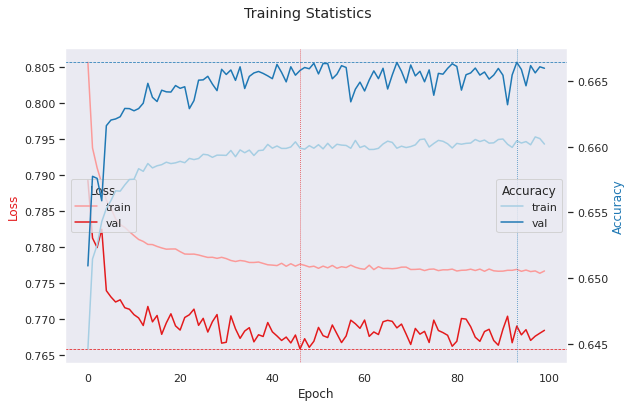

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
sns.set_style("darkgrid", {"grid.color": "0.5"})

fig, loss_ax = plt.subplots(figsize=(9, 5.8))
acc_ax = loss_ax.twinx()

fig.suptitle('Training Statistics')

# Set color
colors = sns.color_palette("Paired")[0:2]
colors.extend(sns.color_palette("Paired")[4:6])

# Loss
sns.lineplot(data=hist.history['loss'], ax=loss_ax, color=colors[2])#, marker='o')
loss_graph = sns.lineplot(data=hist.history['val_loss'], ax=loss_ax, color=colors[3])#, marker='X')

loss_ax.set_ylabel('Loss', color=colors[3])
loss_ax.legend(loc='center left', title='Loss', labels=['train', 'val'])

# Accuracy
sns.lineplot(data=hist.history['accuracy'], ax=acc_ax, color=colors[0])#, marker='o')
acc_graph = sns.lineplot(data=hist.history['val_accuracy'], ax=acc_ax, color=colors[1])#, marker='X')

acc_ax.set_ylabel('Accuracy', color=colors[1])
acc_ax.legend(loc='center right', title='Accuracy', labels=['train', 'val'])

# Mark the lowest Loss
min_loss, min_loss_epoch = get_peak_with_index(min, hist.history['val_loss'])
print(f'min loss : {min_loss} at {min_loss_epoch} epoch')
loss_graph.axhline(min_loss, linestyle='--', linewidth=0.75, color=colors[3])
loss_graph.axvline(min_loss_epoch, linestyle=':', linewidth=0.75, color=colors[3])

# Mark the highest Accuracy
max_acc, max_acc_epoch = get_peak_with_index(max, hist.history['val_accuracy'])
print(f'max acc : {max_acc} at {max_acc_epoch} epoch')
acc_graph.axhline(max_acc, linestyle='--', linewidth=0.75, color=colors[1])
acc_graph.axvline(max_acc_epoch, linestyle=':', linewidth=0.75, color=colors[1])

# Set X ticks
loss_ax.set_xlabel('Epoch')
#loss_ax.set_xticks(list(range(EPOCH_COUNT)))
#loss_ax.set_xticklabels(list(range(1, EPOCH_COUNT+1)))

# Remove grids
loss_ax.grid(False, axis='both')
acc_ax.grid(False, axis='both')

plt.show()

fig.savefig(f"training_statistics.png", transparent=True)

# min loss : 0.7657840847969055 at 46 epoch
# max acc : 0.666427493095398 at 93 epoch

In [ ]:
import numpy as np

# Predict the Test
test_p = model.predict(test_x, verbose=1)
test_p = np.argmax(test_p, axis=1)

# Predict the Validation
val_p = model.predict(val_x, verbose=1)
val_p = np.argmax(val_p, axis=1)

12500/12500 [==============================] - 16s 1ms/step


In [ ]:
import seaborn as sns

def draw_confusion_matrix(groundtruth, prediction, title, palette):
    # Confusion Matrix
    matrix_cnt = tf.math.confusion_matrix(groundtruth, prediction).numpy()
    #print(matrix_cnt)

    matrix_ratio = matrix_cnt / matrix_cnt.sum()
    matrix_ratio = matrix_ratio.round(3)
    #print(matrix_ratio.round(3))

    label_name = ['Negative', 'Neutral', 'Positive']

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    sns.heatmap(matrix_cnt, annot=True, fmt=",", linewidths=.5,
                ax=axes[0], cmap=palette,
                xticklabels=label_name, yticklabels=label_name)

    sns.heatmap(matrix_ratio, annot=True, linewidths=.5,
                ax=axes[1], cmap=palette,
                xticklabels=label_name, yticklabels=label_name)

    fig.suptitle(title)
    plt.show()

    fig.savefig(f"{title.replace(' ', '_')}.png", transparent=True)

In [ ]:
draw_confusion_matrix(val_y, val_p, "Confusion Matrix of Validation dataset",
                      sns.light_palette("seagreen", as_cmap=True))

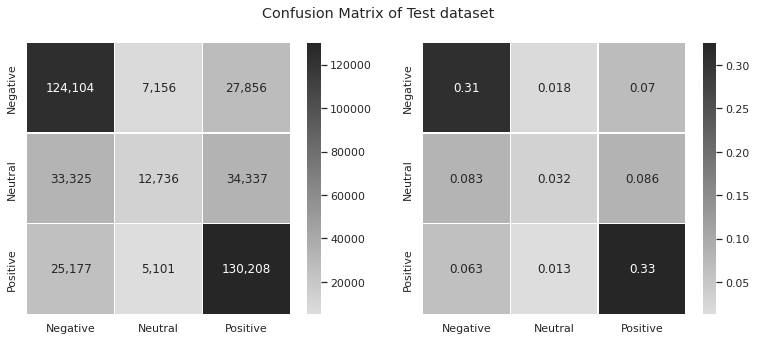

In [ ]:
draw_confusion_matrix(test_y, test_p, "Confusion Matrix of Test dataset",
                      sns.dark_palette("#ddd", as_cmap=True, reverse=True))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_y, val_p, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.68      0.78      0.73    159078
     Neutral       0.51      0.16      0.24     80495
    Positive       0.68      0.81      0.74    160427

    accuracy                           0.67    400000
   macro avg       0.62      0.58      0.57    400000
weighted avg       0.64      0.67      0.63    400000

